In [9]:
import matplotlib.pyplot as plt
import numpy as np

from utils import *

from random import shuffle
import random


## Algorithme de Metropolis-Hasting 

- Il faut avant tout choisir un point $x_0$, comme étant le premier échantillon de notre loi cible, et aussi une probabilité de transition $g$, en donnant les fonctions correspondant à $g_y(x)$ et $g(x)$, $\forall x,y \in \mathfrak{X}$.  

- Ensuite nous itérons sur $t$ allant de 0 à $N$ (notre nombre d'itérations voulu)  
    1. On tire $x$ avec $g_{x_t}(x)$  
    2. On pose $\alpha \coloneqq \frac{ \pi(x) g_x(x_t)}{\pi(x_t) g_{x_t}(x)}$ (notons que si nous ne possédons qu'une densité proportionnelle à $\pi$, $f$ nous pouvons poser $\alpha \coloneqq \frac{ f(x) g_x(x_t)}{f(x_t) g_{x_t}(x)}$)  
    3. On tire $u \in [0;1]$, tel que $u  \sim \mathcal{U}(0,1)$  -
        - Si $u \leqslant \alpha$ alors : $x_{t+1} \coloneqq x$  
        - Sinon : on conserve l'état précédent $x_{t+1} \coloneqq x$  
        
    
- La séquence $\{x_0,x_1, ... ,x_{N-1}\}$ constitue donc l'échantillon obtenue à partir de la chaîne de Markov associé à la loi $\pi$


Voici une implémentation de l'algorithme en python :

# Implémentation de hasting_metropolis :

In [10]:
def next_state_markov(x:int,transitions:np.array)->int:
        return np.random.choice(len(transitions),p=transitions[x])
    


def hasting_metropolis_tirage(x0:int,distribution_cible,proposition : np.array,iterations:int = 1000)->np.array:
    x_t = x0
    tirage = [x_t]

    for _ in range(iterations):
        # tirage de x
        x = next_state_markov(x_t,proposition)

        # a:= (PI(x)*g(x_t|x)) / (PI(x_t)*g(x|x_t))
        pi_xt = distribution_cible(x_t)
        pi_x = distribution_cible(x)
        g_xt_x = proposition[x_t][x]
        g_x_xt = proposition[x][x_t]
        if pi_xt * g_xt_x == 0 : alpha = 1 # on évite la division par 0
        else : alpha = min(1,(pi_x * g_x_xt)/(pi_xt * g_xt_x))

        #on tire u de manière uniforme dans [0;1]
        u = np.random.uniform(0,1)

        # Si u <= a alors : x_(t+1) = x'
        # Sinon : x_(t+1) = x_t
        if u <= alpha : x_t = x
        tirage.append(x_t)

    return np.array(tirage)

def markov_chain_from_tirage(tirage,nb_etats)->np.array:
    sommes = np.full((nb_etats,nb_etats),0)
    derniere_etat = tirage[0]
    for col in tirage[1:]:
        sommes[derniere_etat][col]+=1
        derniere_etat = col
    result = []
    for i in range(nb_etats):
        denominateur =0
        result.append([])
        for col in sommes[i]:
             denominateur += col

        for j in range(nb_etats):
             result[i].append(sommes[i][j]/denominateur)
        
    
    return np.array(result)     
     

def hasting_metropolis(x0:int,distribution_cible,proposition : np.array,iterations:int = 1000)->np.array:
    tirage = hasting_metropolis_tirage(x0,distribution_cible,proposition,iterations = iterations)
    return markov_chain_from_tirage(tirage,proposition.shape[0])
    
    


## Application

In [11]:
# Démonstration petite loi binomial
N = 5

distribution_cible = binomial(N,0.2)

#matrice de transition quelconque
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.random.rand(N) for _ in range(N)]
])


tirage = hasting_metropolis_tirage(0,distribution_cible,proposition,iterations=10_000)
mk_c = markov_chain_from_tirage(tirage,N)

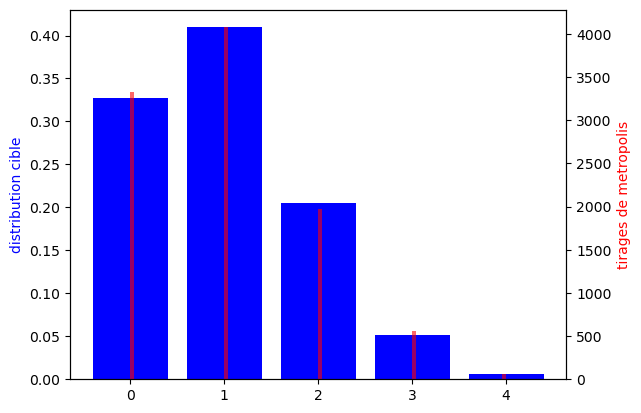

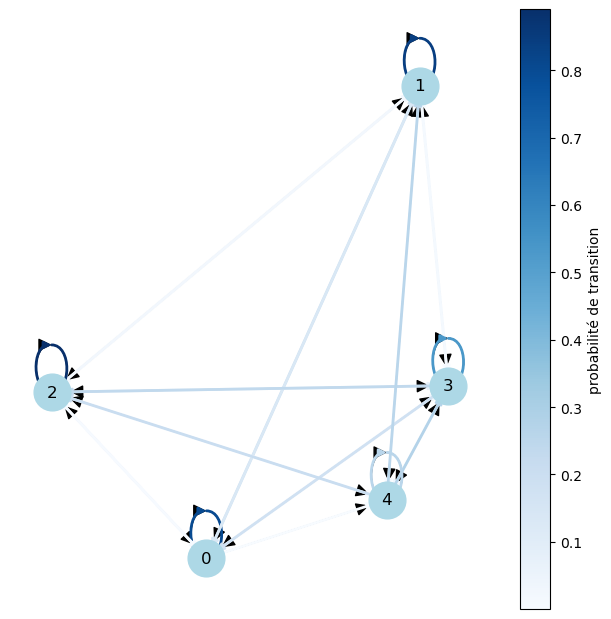

In [12]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

my_plot_graph_mat(mk_c)


plt.show()

In [5]:
# Démonstration loi de poisson
N = 15

distribution_cible = poisson(5)

#matrice de transition uniforme de taille NxN
proposition = np.full((N,N),1/N)

tirage = hasting_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

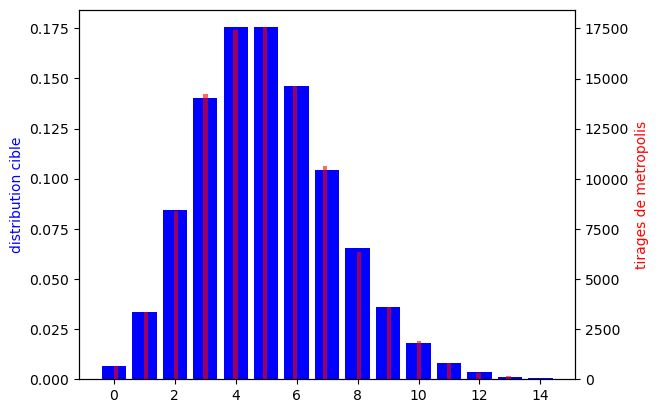

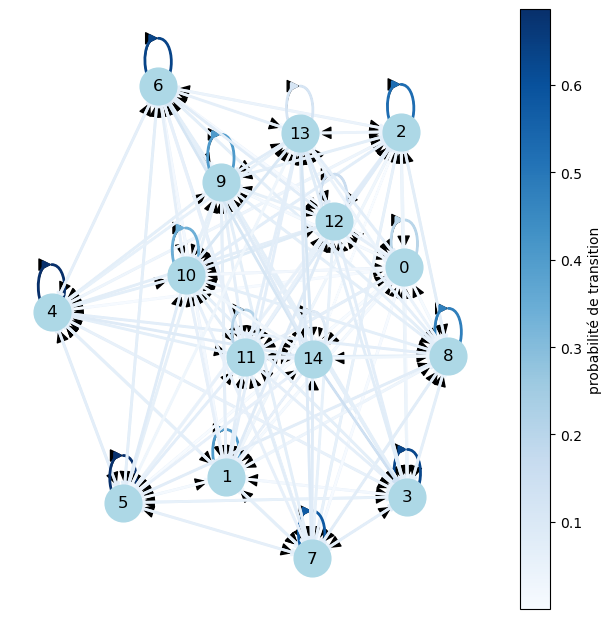

In [6]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

my_plot_graph_mat(mk_c)

plt.show()

In [7]:
# Démonstration loi binomial
N = 17

distribution_cible = binomial(20,0.3)

#matrice de transition
proposition = np.array([[binomial(N-1,0.5)(j) for j in range(N)]for i in range(N)])

tirage = hasting_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

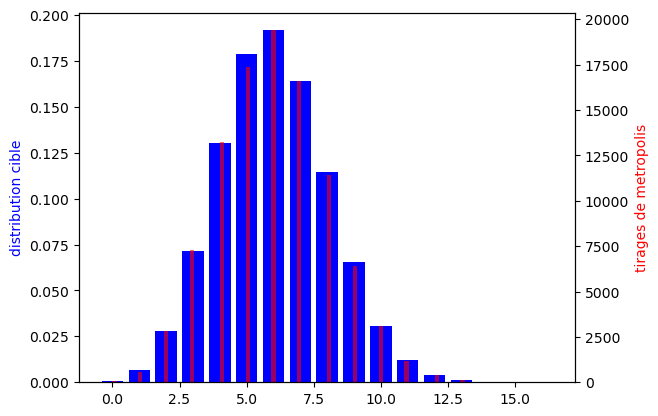

In [8]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.show()

In [9]:
# Démonstration loi uniform

N = 15

distribution_cible = lambda k : 1/(N-2) if 0<k and k<N else 0

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.random.rand(N) for _ in range(N)]
])


tirage = hasting_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

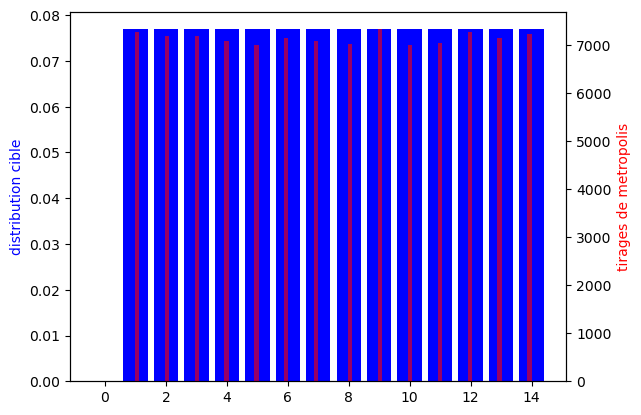

In [10]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")


plt.show()

In [11]:
# Démonstration loi géometrique

N = 20

distribution_cible = geo(0.33)

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.array([abs(np.random.normal(i,1)) for _ in range(N)]) for i in range(N)]
])

tirage = hasting_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

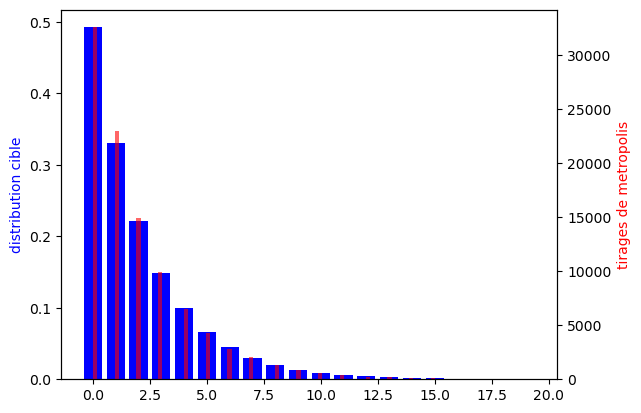

In [12]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.show()

In [13]:
# Démonstration loi quelconque

N = 30

distribution = np.random.rand(N)
distribution = distribution / distribution.sum()

distribution_cible = lambda k : distribution[k] if k < N and 0<=k else 0

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.array([abs(np.random.normal(i,1)) for _ in range(N)]) for i in range(N)]
])

tirage = hasting_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

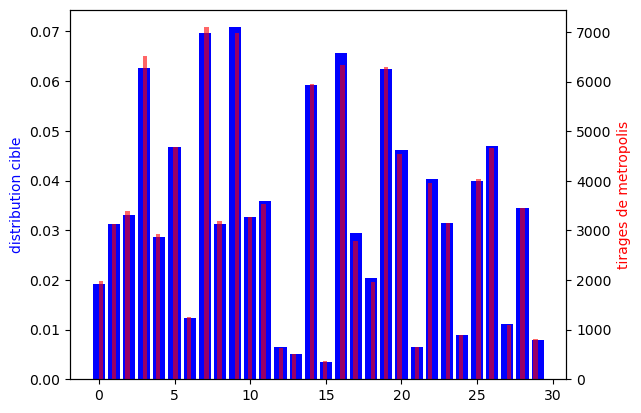

In [14]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")


plt.show()

## Application au problème du voaygeur de commerce

### Algorithme

Nous avons un nombre $n \in \mathbb{N} $ de villes, ordonnés,  $(v_1, v_2, \dots, v_n)$, avec des coordonées donnée par $C(v_i) = (x,y) \in \mathbb{R}^2, \forall i \in [1,n]$

L'ensemble des états $E$, est l'ensembles des combinaisons de nos villes 

Nous posons aussi $\mathcal{D}(X) = \sum_{i=0}^{n-1} \|C(v_i) - C_(v_{i+1}) \| $ ordonnées selon $X$

Nous avons la distributions cible $\pi(X) = e^{-\mathcal{D}(X)/T}$, avec $T \in \mathbb{R} $

Nous définissons la matrice de transition $P$ 

In [15]:
def distance(c1,c2):
    return np.linalg.norm(np.array(c1)-np.array(c2))

def total_distance(path, coord):
    return sum (distance(coord[path[i]],coord[path[i+1]]) for i in range(len(path)-1))

def swap_cities(path):
    new_path = path[:]
    i, j = random.sample(range(len(path)), 2)
    new_path[i], new_path[j] = new_path[j], new_path[i]
    return new_path

def next_state_markov(path,_p):
    
    return swap_cities(path) 


In [16]:
N = 5

villes = [tuple(np.random.rand(2) * 100) for _ in range(N)]

path = list(range(N))
shuffle(path)
best_path = path[:]
best_distance = total_distance(best_path,villes)

distribution_cible = lambda path, T=10 : np.exp(-total_distance(path,villes)/T)

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.array([abs(np.random.normal(i,1)) for _ in range(N)]) for i in range(N)]
])

tirage = hasting_metropolis_tirage(path,distribution_cible,proposition)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()